In [3]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import SAGEConv
import torch
import torch_geometric
import torch.nn.functional as F
torch_geometric.set_debug(True)

# Helper Function to Construct the Graph

In [4]:
def mapping(data: pd.DataFrame):
    node_id_mapping, inverse_node_id_mapping = dict(), dict()
    for i, node_id in enumerate(data['image_name']):
        node_id_mapping[i] = node_id
        inverse_node_id_mapping[node_id] = i
    return node_id_mapping, inverse_node_id_mapping

In [5]:
def construct_nodes(data: pd.DataFrame):
    raw_features = data['embedding'].apply(lambda x: (' '.join(x.strip('[').strip(']').strip().split())).split(' '))
    return torch.from_numpy(np.array([[float(val) for val in feature_vector] for feature_vector in raw_features])).to(torch.float32)

In [6]:
def construct_edges(features: torch.tensor, threshold: float, method):
    source, target = [], []
    for i in tqdm(range(features.shape[0])):
        for j in range(i + 1, features.shape[0]):
            if method(features[i], features[j]) > threshold:
                source.append(i)
                target.append(j)
                source.append(j)
                target.append(i)
    return torch.tensor([source, target])

In [7]:
def get_labels(data: pd.DataFrame, subject_mapping):
    labels = data['class_name'].apply(lambda x: subject_mapping[x])
    return torch.tensor(labels)

In [8]:
def cosine_similarity(x: torch.tensor, y: torch.tensor):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    return cos(x,y)

def city_block(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=1)

def euclidian(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=2)

# Reading the Data and Exploring

In [289]:
data = pd.read_csv('imagenet_embeddings.csv')

In [290]:
classes = data['class_name'].unique()
subject_mapping = dict()
reverse_subject_mapping = dict()
for i, class_name in enumerate(classes):
    subject_mapping[class_name] = i
    reverse_subject_mapping[i] = class_name
subject_mapping

{'lion': 0, 'bear': 1, 'tarantula': 2, 'golden retriever': 3}

In [291]:
x = construct_nodes(data)
y = get_labels(data, subject_mapping)

In [244]:
def construct_matrix(matrix, method):
    n = matrix.shape[0]
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            similarity_matrix[i][j] = method(matrix[i], matrix[j])
    return similarity_matrix

In [251]:
from sklearn.metrics.pairwise import cosine_similarity
similarities =  torch.cdist(x, x, p=2)

In [252]:
def one_vs_rest(one_class: int, rest: np.array):
    same_class = []
    classes = [[], [], []]
    for i in range(500):
        same_class.append((sum(one_class[i]) - 1) / (len(one_class[i] - 1)))
        for j in range(3):
            rest_class = rest[i][j*500:(j+1)*500]
            classes[j].append(sum(rest_class) / len(rest_class))
    classes.append(same_class)
    return classes

In [253]:
test = []
for i in tqdm(range(4)):
    relevant_indeces = list(range(i * 500, (i+1) * 500))
    not_relevant = [k for k in range(2000) if k not in relevant_indeces] 
    one_class, rest = [], []
    for i in range(2000):
        if i in relevant_indeces:
            one_class.append(similarities[i])
        else:
            rest.append(similarities[i])
    test.append(one_vs_rest(one_class, rest))


100%|██████████| 4/4 [00:31<00:00,  7.99s/it]


In [254]:
# np.array(test[0][2]).mean()
for class_num, scores in enumerate(test):
    other_classes = []
    for i in range(3):
        other_classes.append(np.array(scores[i]).mean())
    print(reverse_subject_mapping[class_num], np.array(scores[3]).mean(), other_classes)

lion 0.7963455 [0.7998037, 0.7788479, 0.8427239]
bear 0.80841726 [0.7596558, 0.7998037, 0.82955945]
tarantula 0.83079946 [0.7596558, 0.7998037, 0.82955945]
golden retriever 0.80665183 [0.7596558, 0.7998037, 0.82955945]


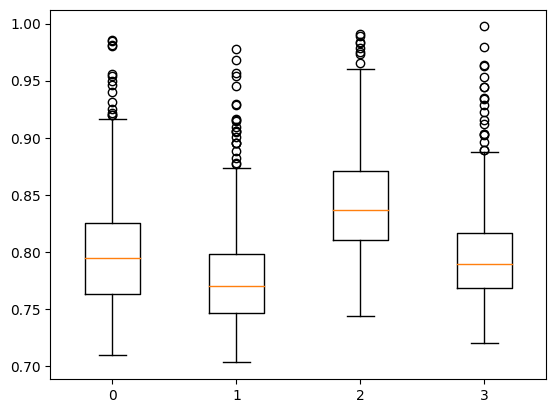

In [259]:
import matplotlib.pyplot as plt

plt.boxplot(test[0], positions=range(len(test[1])))
plt.show()

In [292]:
np.percentile(test[3][3], [10, 50, 90])

TypeError: 'function' object is not subscriptable

In [293]:
source, target = [], []
for i in tqdm(range(similarities.shape[0])):
    for j in range(similarities.shape[1]):
        if 0.83 < similarities[i][j] and i != j:
            source.append(i)
            target.append(j)
edges = torch.tensor([source, target])

100%|██████████| 2000/2000 [00:59<00:00, 33.85it/s]


In [294]:
train_indeces = list(range(0,400)) + list(range(500,900)) + list(range(1000,1400)) + list(range(1500,1900))
valid_indeces = list(range(400,450)) + list(range(900,950)) + list(range(1400,1450)) + list(range(1900,1950))
test_indeces = list(range(450,500)) + list(range(950,1000)) + list(range(1450,1500)) + list(range(1950,2000))

In [295]:
train_mask = torch.tensor([1 if i in train_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if i in valid_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if i in test_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [296]:
from torch_geometric.data import Data

data = Data(x=x, y=y, edge_index=edges, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)

In [297]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//2, normalize=True)
        self.conv3 = SAGEConv((-1, -1), hidden_channels//4, normalize=True)
        self.conv4 = SAGEConv((-1, -1), output_dim, normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        # x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

In [41]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels//2, aggr="mean", normalize=True)
        self.conv2 = SAGEConv((-1, -1), output_dim, aggr="mean", normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [298]:
output_dim = len(subject_mapping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)


In [299]:
def train():
    # TODO: Complete this function
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

In [300]:
def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, valid_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [301]:
best_val_acc = test_acc = 0
for epoch in tqdm(range(1,101)):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

 10%|█         | 10/100 [01:11<10:53,  7.26s/it]

Epoch: 010, Val: 0.5500, Test: 0.5100


 20%|██        | 20/100 [02:24<09:36,  7.20s/it]

Epoch: 020, Val: 0.7550, Test: 0.7000


 30%|███       | 30/100 [03:36<08:27,  7.25s/it]

Epoch: 030, Val: 0.8050, Test: 0.7400


 40%|████      | 40/100 [04:49<07:12,  7.20s/it]

Epoch: 040, Val: 0.8550, Test: 0.8200


 50%|█████     | 50/100 [06:01<05:58,  7.16s/it]

Epoch: 050, Val: 0.8850, Test: 0.8500


 60%|██████    | 60/100 [07:13<04:48,  7.21s/it]

Epoch: 060, Val: 0.8850, Test: 0.8500


 70%|███████   | 70/100 [08:25<03:35,  7.19s/it]

Epoch: 070, Val: 0.9000, Test: 0.8800


 80%|████████  | 80/100 [09:38<02:30,  7.50s/it]

Epoch: 080, Val: 0.9000, Test: 0.8800


 90%|█████████ | 90/100 [10:51<01:12,  7.24s/it]

Epoch: 090, Val: 0.9000, Test: 0.8800


100%|██████████| 100/100 [12:04<00:00,  7.25s/it]

Epoch: 100, Val: 0.9000, Test: 0.8800
